1. Revisit the St. John’s temperature prediction problem, this time with recurrent neural networks. That is, repeat all the steps from Assignment 2 (Question 2), now using persistence, linear regression and your MLP network as baselines and develop suitable recurrent neural networks (e.g. using LSTMs, GRUs, simple RNNs, etc.). Can your recurrent neural network architectures beat all the other methods you have implemented for Assignment 2?


2. We have briefly seen the WaveNet architecture in class. Here, the goal is to implement this architecture from scratch in Keras. For this, complete the following steps:
(a) Read the original WaveNet paper: https://arxiv.org/abs/1609.03499. Note that
the original WaveNet architecture was designed as generative model for raw audios, but since audio data can be interpreted as very long time series, WaveNets can also be used for general time series data.
(b) The key architectural element of WaveNets is the WaveNet block, which is described in Figure 4 of the paper. Implement this WaveNet block using Keras’ functional (or subclassing) API.
(c) Once you have implemented the WaveNet architecture, use it for the St John’s temperature prediction problem as in Question 1. What are your observations in terms of training speed and accuracy in comparison to the other models you have implemented for this task so far?

In [1]:
from google.colab import drive
! pip install netCDF4
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from pandas import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
!pip install -q -U keras-tuner
import keras_tuner as kt
from matplotlib import figure
import matplotlib.pyplot as plt
#import seaborn as sns
from numpy import array
! pip install xarray
import xarray as xr
import os
from tensorflow.keras.utils import plot_model


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-1-66061ddb9c23>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Mount drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ncfid = Dataset('/content/drive/MyDrive/tempStJohns_v2.nc')

In [4]:
print(ncfid)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2021-02-03 00:49:51 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data2/adaptor.mars.internal-1612306467.0641284-4955-27-685dbd6e-9572-4267-a9a7-5a61b7e919e4.nc /cache/tmp/685dbd6e-9572-4267-a9a7-5a61b7e919e4-adaptor.mars.internal-1612306467.0646257-4955-9-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), expver(2), time(87672)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 t2m(time, expver, latitude, longitude)
    groups: 


In [5]:
# Load in temperature data (and convert to celcius)
temp = ncfid['t2m'][:, 0,0,0]-273.15
temp

masked_array(data=[-0.3391920819591405, -0.4932865862010658,
                   -0.36627145090540125, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-32767)

In [6]:
time = ncfid['time']
time

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (87672,)
filling on, default _FillValue of -2147483647 used

In [7]:
# total number of data points missing
np.sum([int(i) for i in temp.mask])


744

In [8]:
temp2 = temp[temp.mask == False]
temp2.shape

(86928,)

In [9]:
time2 = time[temp.mask == False]
time2.shape

(86928,)

In [10]:
df = pd.DataFrame({'time': time2, 't2m': temp2})
df

,time,t2m
0,973008,-0.339192
1,973009,-0.493287
2,973010,-0.366271
3,973011,-0.172847
4,973012,-0.265691
...,...,...
86923,1059931,3.799438
86924,1059932,1.655655
86925,1059933,1.535087
86926,1059934,0.540887


In [11]:
# convert the current index of the DataFrame df3 to datetime objects with the time unit specified as hours (unit='h'), and creates a new column 'time' in df3 to store these values.

df['time'] = pd.to_datetime(df.index, unit='h')

# set the values in the 'time' column of the DataFrame df3 as the index of the DataFrame.

df1 = df.set_index('time')
df1

,t2m
time,
1970-01-01 00:00:00,-0.339192
1970-01-01 01:00:00,-0.493287
1970-01-01 02:00:00,-0.366271
1970-01-01 03:00:00,-0.172847
1970-01-01 04:00:00,-0.265691
...,...
1979-12-01 19:00:00,3.799438
1979-12-01 20:00:00,1.655655
1979-12-01 21:00:00,1.535087


In [12]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
  # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
  # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
  # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [13]:
n_steps_in = 12
n_steps_out = 6

In [14]:
X, y = split_sequence(df1, n_steps_in, n_steps_out)

In [15]:
n_inputs1 = X.shape[2] * X.shape[1]
n_inputs2 = y.shape[2] * y.shape[1]
XC = X.reshape(X.shape[0], n_inputs1)
yC = y.reshape(y.shape[0], n_inputs2)

In [16]:
print(XC.shape)
print(yC.shape)

(86911, 12)
(86911, 6)


In [17]:
def split_data(XC, yC, test_size=0.2):
    n_samples = XC.shape[0]
    n_test_samples = int(n_samples * test_size)
    X_train, y_train = XC[:-n_test_samples], yC[:-n_test_samples]
    X_test, y_test = XC[-n_test_samples:], yC[-n_test_samples:]
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = split_data(XC, yC, test_size=0.2)

In [18]:
# Normalize the Data
train_max = np.max(X_train)
train_min = np.min(X_train)

X_train = (X_train - train_min)/(train_max - train_min)
X_test = (X_test - train_min)/(train_max - train_min)
y_train = (y_train - train_min)/(train_max - train_min)
y_test = (y_test - train_min)/(train_max - train_min)


### Develop suitable baseline models. The simplest baseline for a prediction task like this is the so-called persistence prediction: You simply assume that the temperature for the next 6 hours will be the same as the last observed temperature. A second baseline is a simple linear regression model.

### persistence model (first baseline model)

In [19]:
pers_pred = np.repeat(np.expand_dims(X_test[:, n_steps_in-1], axis=1), n_steps_out, axis = 1)


### linear regression model (second baseline model)

In [20]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict using linear regression model
lm_pred = lm.predict(X_test)


### Define and Train MLP model

In [21]:
inp = tf.keras.layers.Input(shape=(n_steps_in,))
b = tf.keras.layers.Dense(units = 128, activation = 'relu')(inp)
b = tf.keras.layers.Dense(units = 128, activation = 'relu')(b)
outp = tf.keras.layers.Dense(n_steps_out, activation = 'linear')(b)

model = tf.keras.models.Model(inp, outp)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 128)               1664      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 18,950
Trainable params: 18,950
Non-trainable params: 0
_________________________________________________________________


### Compile the model

In [22]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

In [23]:
history = model.fit(X_train, y_train, batch_size = 64, epochs = 20, validation_split = 0.1)

Epoch 1/20
978/978 [==============================] - 10s 6ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 2/20
978/978 [==============================] - 6s 6ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 3/20
978/978 [==============================] - 3s 3ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/20
978/978 [==============================] - 3s 3ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 5/20
978/978 [==============================] - 3s 3ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 6/20
978/978 [==============================] - 4s 4ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 7/20
978/978 [==============================] - 3s 3ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/20
978/978 [==============================] - 3s 4ms/step - loss: 0

In [24]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  
  plt.figure()

  plt.semilogy(epochs, loss, 'b', label = 'Training Loss')
  plt.semilogy(epochs, val_loss, 'r', label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  
  plt.show()

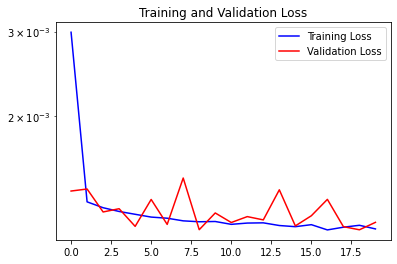

In [25]:
plot_train_history(history, 'Training and Validation Loss')

### DEFINE AND TRAIN LSTM Model

In [26]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.InputLayer((n_steps_in, 1)))
lstm_model.add(tf.keras.layers.LSTM(128))
lstm_model.add(tf.keras.layers.Dense(64, 'relu'))
lstm_model.add(tf.keras.layers.Dense(32, 'relu'))
lstm_model.add(tf.keras.layers.Dense(n_steps_out, 'linear'))
lstm_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 77,094
Trainable params: 77,094
Non-trainable params: 0
_________________________________________________________________


In [27]:
# compiling the model
lstm_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

history1 = lstm_model.fit(X_train, y_train, batch_size = 64, epochs = 20, validation_split = 0.1)



Epoch 1/20
978/978 [==============================] - 9s 6ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 2/20
978/978 [==============================] - 6s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 3/20
978/978 [==============================] - 5s 5ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/20
978/978 [==============================] - 7s 7ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 5/20
978/978 [==============================] - 5s 5ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/20
978/978 [==============================] - 7s 7ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/20
978/978 [==============================] - 6s 6ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/20
978/978 [==============================] - 5s 5ms/step - loss: 0.

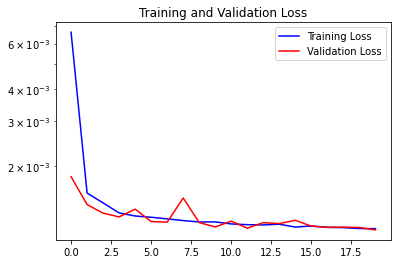

In [28]:
plot_train_history(history1, 'Training and Validation Loss')

### DEFINE AND TRAIN GRU Model

In [29]:
gru_model = tf.keras.Sequential()
gru_model.add(tf.keras.layers.InputLayer((n_steps_in, 1)))
gru_model.add(tf.keras.layers.GRU(128))
gru_model.add(tf.keras.layers.Dense(64, 'relu'))
gru_model.add(tf.keras.layers.Dense(32, 'relu'))
gru_model.add(tf.keras.layers.Dense(n_steps_out, 'linear'))
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 6)                 198       
                                                                 
Total params: 60,838
Trainable params: 60,838
Non-trainable params: 0
_________________________________________________________________


In [30]:
# compiling the model
gru_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

history2 = gru_model.fit(X_train, y_train, batch_size = 64, epochs = 20, validation_split = 0.1)

Epoch 1/20
978/978 [==============================] - 9s 7ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 2/20
978/978 [==============================] - 5s 5ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/20
978/978 [==============================] - 6s 6ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/20
978/978 [==============================] - 6s 6ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 5/20
978/978 [==============================] - 6s 6ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 6/20
978/978 [==============================] - 6s 6ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 7/20
978/978 [==============================] - 5s 5ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/20
978/978 [==============================] - 6s 6ms/step - loss: 0.

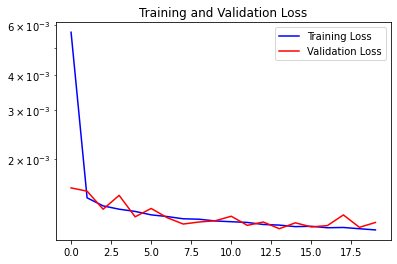

In [31]:
plot_train_history(history2, 'Training and Validation Loss')

### DEFINE AND TRAIN SimpleRNN Model

In [32]:
simplernn_model = tf.keras.Sequential()
simplernn_model.add(tf.keras.layers.InputLayer((n_steps_in, 1)))
simplernn_model.add(tf.keras.layers.SimpleRNN(128, activation='tanh', dropout=0.0, recurrent_dropout=0.0, unroll=False))
simplernn_model.add(tf.keras.layers.Dense(64, 'relu'))
simplernn_model.add(tf.keras.layers.Dense(32, 'relu'))
simplernn_model.add(tf.keras.layers.Dense(n_steps_out, 'linear'))
simplernn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 6)                 198       
                                                                 
Total params: 27,174
Trainable params: 27,174
Non-trainable params: 0
_________________________________________________________________


In [33]:
# compiling the model
simplernn_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

history3 = simplernn_model.fit(X_train, y_train, batch_size = 64, epochs = 20, validation_split = 0.1)

Epoch 1/20
978/978 [==============================] - 16s 13ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 2/20
978/978 [==============================] - 13s 14ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 3/20
978/978 [==============================] - 13s 13ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/20
978/978 [==============================] - 13s 13ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 5/20
978/978 [==============================] - 14s 14ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 6/20
978/978 [==============================] - 13s 13ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/20
978/978 [==============================] - 16s 16ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/20
978/978 [==============================] - 13s 14ms

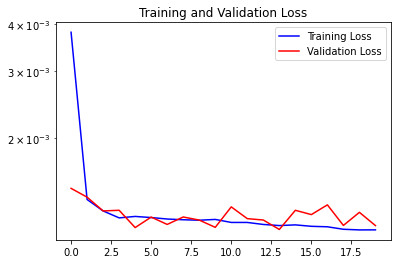

In [34]:
plot_train_history(history3, 'Training and Validation Loss')

### Wavenet Architecture

In [35]:
import tensorflow as tf
from tensorflow import keras

class wavenetblock(tf.keras.layers.Layer):
  def __init__(self, filters, filter_size, dilation):
    super(wavenetblock, self).__init__()
    self.conv_s = tf.keras.layers.Conv1D(filters, filter_size, padding='same', dilation_rate=dilation)
    self.conv_t = tf.keras.layers.Conv1D(filters, filter_size, padding='same', dilation_rate=dilation)
    self.tanh = tf.keras.layers.Activation('tanh')
    self.sigmoid = tf.keras.layers.Activation('sigmoid')
    self.multiply = tf.keras.layers.Multiply()
    self.conv1 = tf.keras.layers.Conv1D(filters, 1, padding='same')
    self.conv2 = tf.keras.layers.Conv1D(filters, 1, padding='same')
    self.add = tf.keras.layers.Add()

  def call(self, inputs):
    xs = self.conv_s(inputs)
    xt = self.conv_t(inputs)
    x_tanh = self.tanh(xt)
    x_sigmoid = self.sigmoid(xs)
    x_multiply = self.multiply([x_tanh, x_sigmoid])
    skip = self.conv1(x_multiply)
    res = self.conv2(x_multiply)
    out = self.add([res, inputs])

    return out, skip

def build_wavenet(input_shape, filters, filter_size, dilations, n_steps_out):
  inputs = tf.keras.layers.Input(shape=input_shape)
  x = tf.keras.layers.Conv1D(filters, filter_size, padding='causal')(inputs)
  skip_connections = []
  for dilation in dilations:
    res, skip = wavenetblock(filters, filter_size, dilation)(x)
    skip_connections.append(skip)
    res = tf.keras.layers.Concatenate()([x, res])
  x = tf.keras.layers.Add()(skip_connections)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv1D(filters, 1, padding='same')(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv1D(filters, 1, padding='same')(x)

  x = tf.keras.layers.Flatten()(x)
  outputs = tf.keras.layers.Dense(n_steps_out, 'linear')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

input_shape = (n_steps_in, 1)
filters = 64
n_steps_out = 6
filter_size = 2
dilations = [1, 2, 4, 8, 16, 32]

wavenet_model = build_wavenet(input_shape, filters, filter_size, dilations, n_steps_out)
wavenet_model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 12, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 12, 64)       192         ['input_5[0][0]']                
                                                                                                  
 wavenetblock (wavenetblock)    ((None, 12, 64),     24832       ['conv1d[0][0]']                 
                                 (None, 12, 64))                                                  
                                                                                                  
 wavenetblock_1 (wavenetblock)  ((None, 12, 64),     24832       ['conv1d[0][0]']           

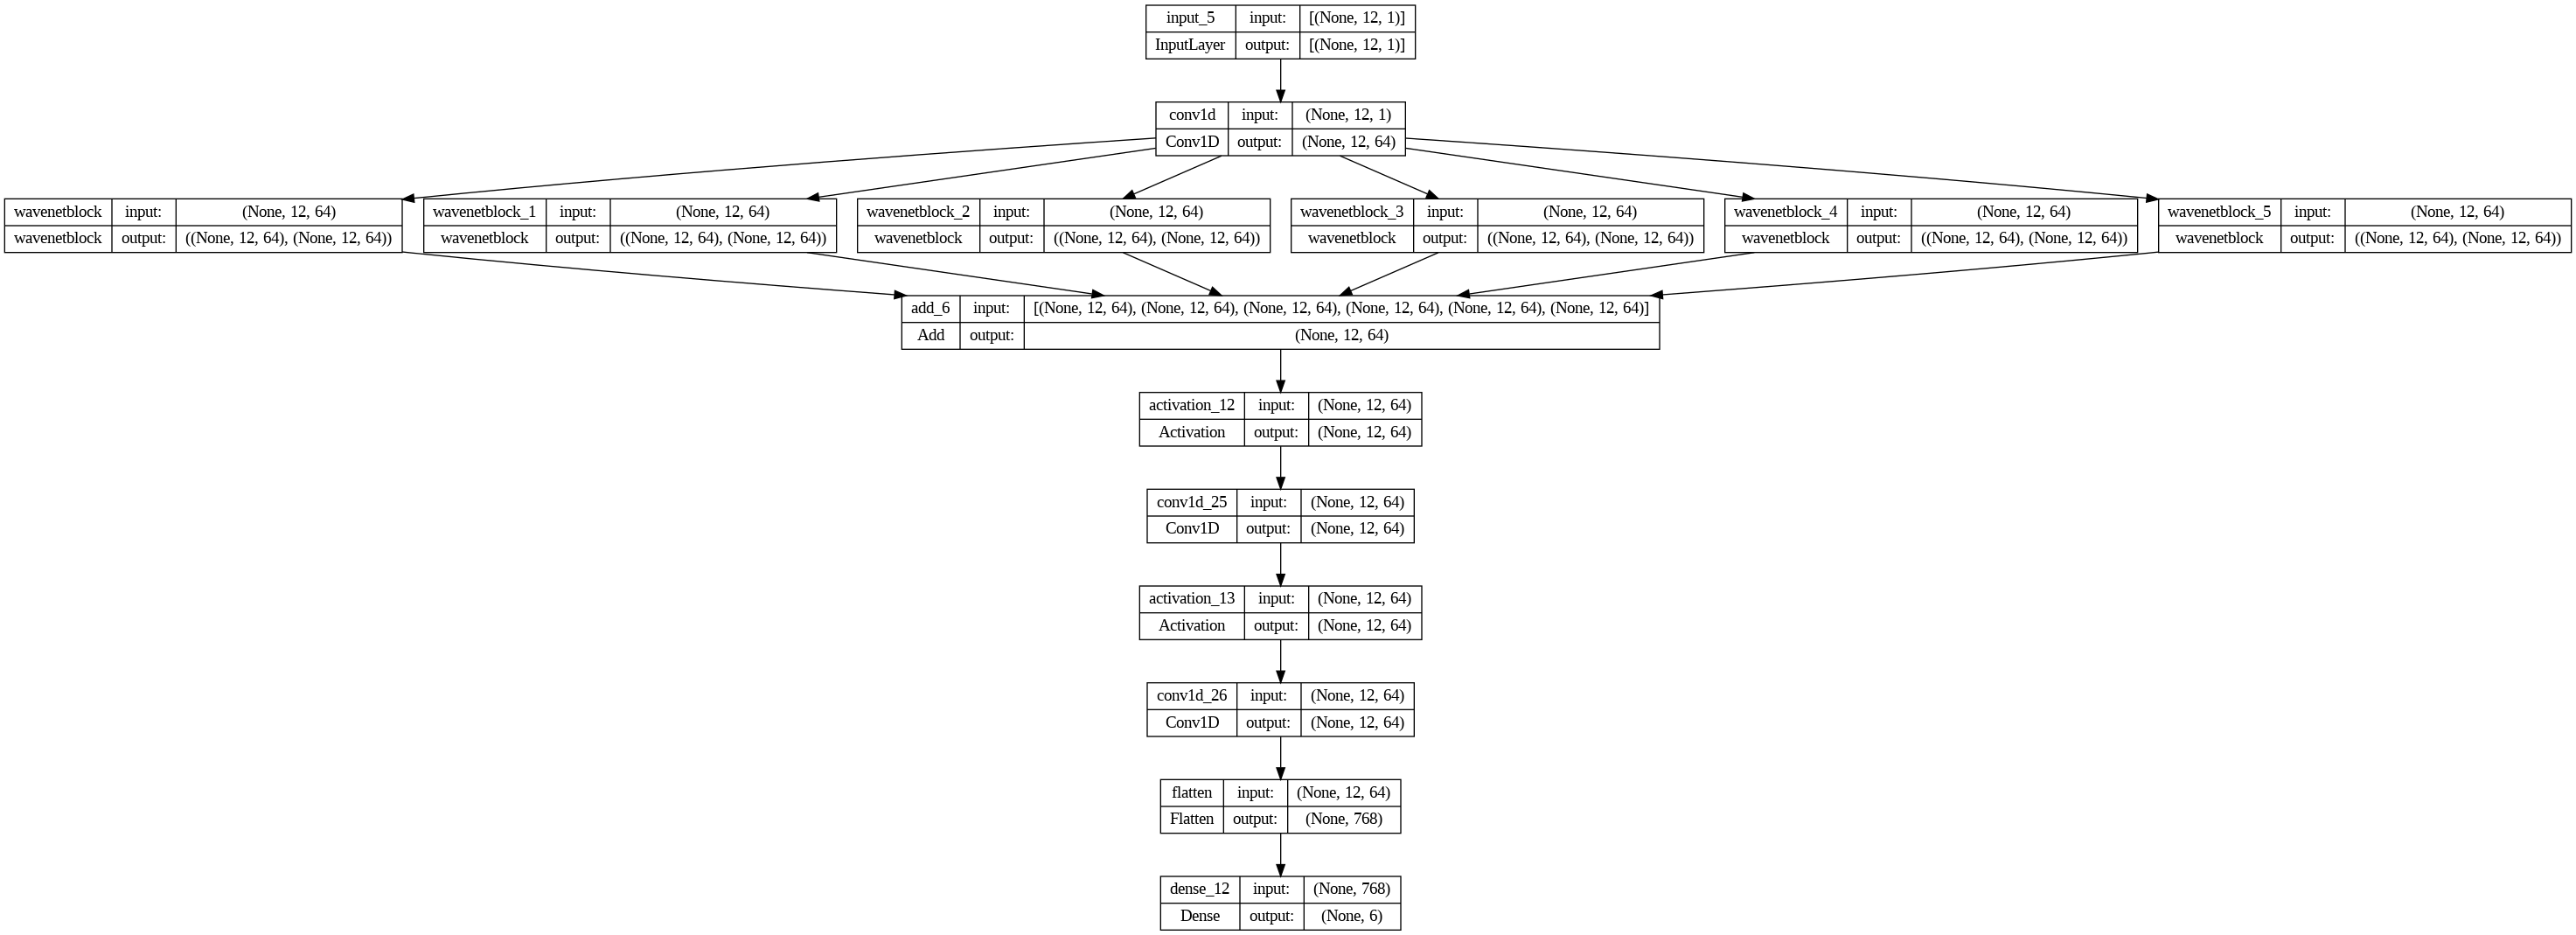

In [36]:
plot_model(wavenet_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [37]:
# compiling the model
wavenet_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

history4 = wavenet_model.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_split = 0.1)

Epoch 1/20


1956/1956 [==============================] - 41s 17ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 2/20
1956/1956 [==============================] - 30s 15ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 3/20
1956/1956 [==============================] - 30s 15ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/20
1956/1956 [==============================] - 32s 16ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/20
1956/1956 [==============================] - 29s 15ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 6/20
1956/1956 [==============================] - 31s 16ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/20
1956/1956 [==============================] - 31s 16ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/20
1956/1956 [==============================] - 31s

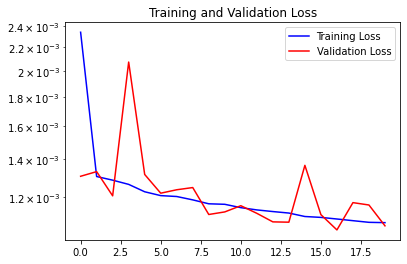

In [38]:
plot_train_history(history4, 'Training and Validation Loss')

In [39]:
# Prediction on test datasets for WaveNet
wavenet_pred = wavenet_model.predict(X_test)

# Prediction on test datasets for simpleRNN
simplernn_pred = simplernn_model.predict(X_test)

# Prediction on test datasets for GRU
gru_pred = gru_model.predict(X_test)

# Prediction on test datasets for LSTM
lstm_pred = lstm_model.predict(X_test)

# Prediction on test datasets for MLP
mlp_pred = model.predict(X_test)

# Prediction on test datasets for Linear
lm_pred = lm.predict(X_test)

# Persistence Prediction
pers_pred = np.repeat(np.expand_dims(X_test[:, n_steps_in-1], axis = 1), n_steps_out, axis = 1)

544/544 [==============================] - 1s 2ms/step


### Visualize some of the predictions from all models
### Reverse the Normalization

In [40]:
def plot_results(x, true_pred, lm_pred, pers_pred, mlp_pred, lstm_pred, gru_pred, simplernn_pred, wavenet_pred, ix):


  x = (train_max - train_min)*x + train_min
  true_pred = (train_max - train_min)*true_pred + train_min
  pers_pred = (train_max - train_min)*pers_pred + train_min
  lm_pred = (train_max - train_min)*lm_pred + train_min
  mlp_pred = (train_max - train_min)*mlp_pred + train_min
  lstm_pred = (train_max - train_min)*lstm_pred + train_min
  gru_pred = (train_max - train_min)*gru_pred + train_min
  simplernn_pred = (train_max - train_min)*simplernn_pred + train_min
  wavenet_pred = (train_max - train_min)*wavenet_pred + train_min

# Input Data
  plt.plot(np.arange(-n_steps_in+1, 1), x[ix], 'k--')

#Persistence Prediction
  plt.plot(np.arange(1, n_steps_out+1), pers_pred[ix], 'g')

# MLP prediction
  plt.plot(np.arange(1, n_steps_out+1), mlp_pred[ix], 'b')

# LSTM prediction
  plt.plot(np.arange(1, n_steps_out+1), lstm_pred[ix], 'm')

# GRU prediction
  plt.plot(np.arange(1, n_steps_out+1), gru_pred[ix], 'c')

# SimpleRNN prediction
  plt.plot(np.arange(1, n_steps_out+1), simplernn_pred[ix], 'y')

# WaveNet prediction
  plt.plot(np.arange(1, n_steps_out+1), wavenet_pred[ix], 'w')

#True Observed Future
  plt.plot(np.arange(1, n_steps_out+1), true_pred[ix], 'r')

#Legend
  plt.legend(["Input Tempt", "Persistence", "Linear", "MLP", "LSTM", "GRU", "SimpleRNN", "WaveNet", "True Tempt"])
  plt.grid()
  plt.xlabel("Input [h]")
  plt.ylabel("Temperature [c]")

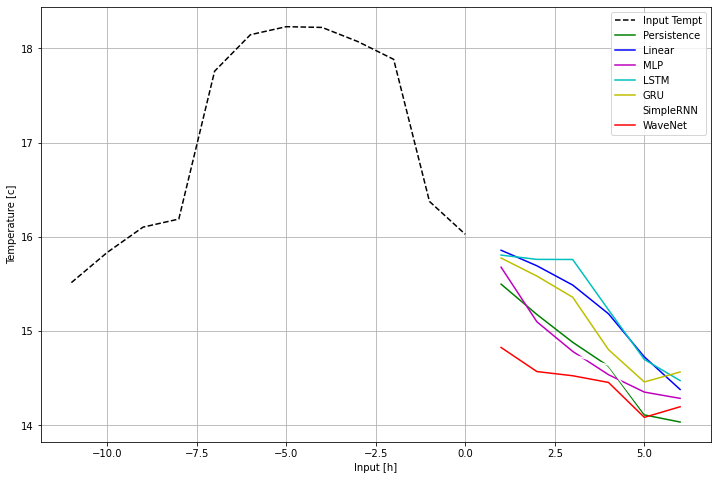

In [41]:
plt.figure(figsize=(12, 8))

plot_results(X_test, y_test, pers_pred, lm_pred, mlp_pred, lstm_pred, gru_pred, simplernn_pred, wavenet_pred, np.random.randint(0, len(y_test)))

### Verify the models on the test dataset, using the mean squared error as verification metric. In particular, plot the mean squared error of the models as a function of the prediction time step

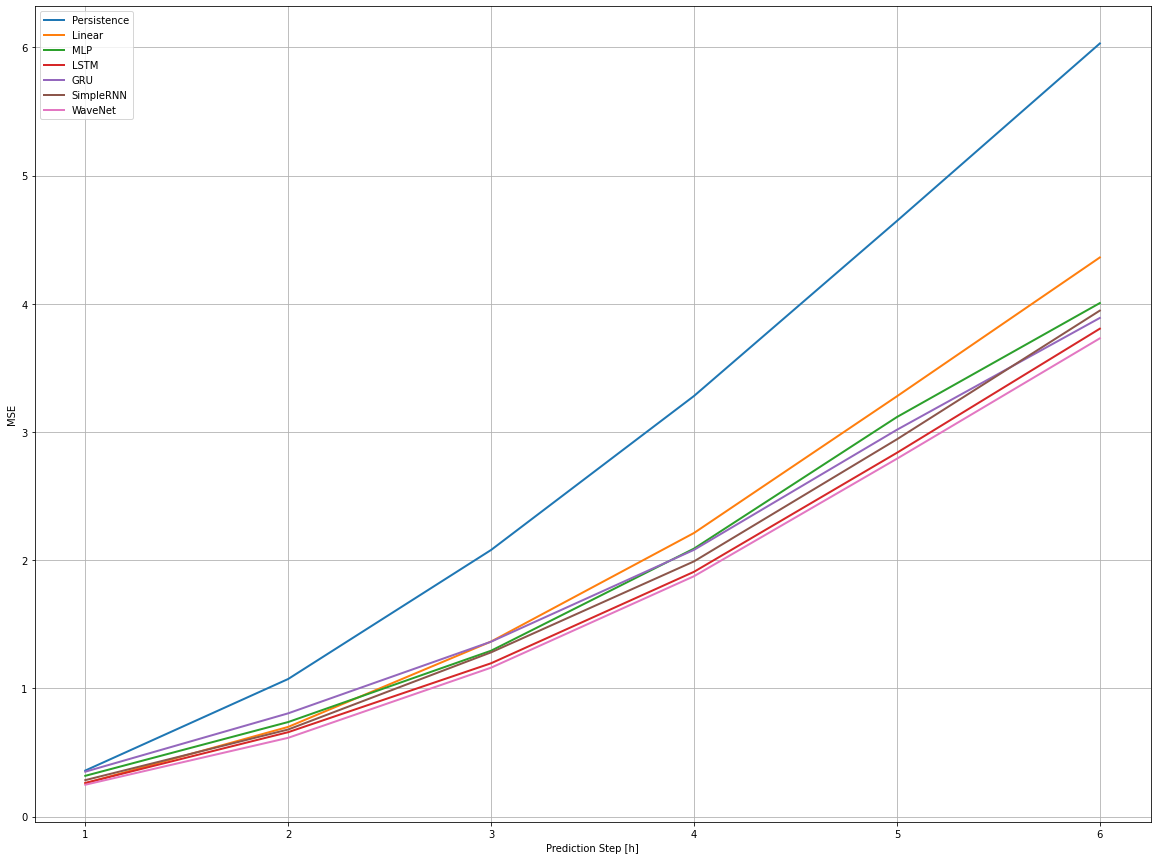

In [42]:
pers_mse = np.zeros(n_steps_out)
lm_mse = np.zeros(n_steps_out)
mlp_mse = np.zeros(n_steps_out)
lstm_mse = np.zeros(n_steps_out)
gru_mse = np.zeros(n_steps_out)
simplernn_mse = np.zeros(n_steps_out)
wavenet_mse = np.zeros(n_steps_out)

for i in range(n_steps_out):
  pers_mse[i] = np.mean(np.square(y_test[:, i] - pers_pred[:, i]))
  lm_mse[i] = np.mean(np.square(y_test[:, i] - lm_pred[:, i]))
  mlp_mse[i] = np.mean(np.square(y_test[:, i] - mlp_pred[:, i]))
  lstm_mse[i] = np.mean(np.square(y_test[:, i] - lstm_pred[:, i]))
  gru_mse[i] = np.mean(np.square(y_test[:, i] - gru_pred[:, i]))
  simplernn_mse[i] = np.mean(np.square(y_test[:, i] - simplernn_pred[:, i]))
  wavenet_mse[i] = np.mean(np.square(y_test[:, i] - wavenet_pred[:, i]))

plt.figure(figsize=(20,15))
plt.plot(np.arange(1, n_steps_out+1), pers_mse*(train_max - train_min)**2, linewidth=2)
plt.plot(np.arange(1, n_steps_out+1), lm_mse*(train_max - train_min)**2, linewidth=2)
plt.plot(np.arange(1, n_steps_out+1), mlp_mse*(train_max - train_min)**2, linewidth=2)
plt.plot(np.arange(1, n_steps_out+1), lstm_mse*(train_max - train_min)**2, linewidth=2)
plt.plot(np.arange(1, n_steps_out+1), gru_mse*(train_max - train_min)**2, linewidth=2)
plt.plot(np.arange(1, n_steps_out+1), simplernn_mse*(train_max - train_min)**2, linewidth=2)
plt.plot(np.arange(1, n_steps_out+1), wavenet_mse*(train_max - train_min)**2, linewidth=2)

plt.legend(["Persistence", "Linear", "MLP", "LSTM", "GRU", "SimpleRNN", "WaveNet"])
plt.xlabel("Prediction Step [h]")
plt.ylabel("MSE")
plt.grid()

In [43]:
mse_pers = mean_squared_error(y_test, pers_pred)
mse_lm = mean_squared_error(y_test, lm_pred)
mse_NN = mean_squared_error(y_test, mlp_pred)
mse_lstm = mean_squared_error(y_test, lstm_pred)
mse_gru = mean_squared_error(y_test, gru_pred)
mse_simplernn = mean_squared_error(y_test, simplernn_pred)
mse_wavenet = mean_squared_error(y_test, wavenet_pred)

In [44]:
print("mean squared error for the persistence model is : ", mse_pers)
print("mean squared error for the linear regression model is: ", mse_lm)
print("mean squared error for the MLP model is : ", mse_NN)
print("mean squared error for the LSTM model is : ", mse_lstm)
print("mean squared error for the GRU model is : ", mse_gru)
print("mean squared error for the SimpleRNN model is : ", mse_simplernn)
print("mean squared error for the WaveNet model is : ", mse_wavenet)

mean squared error for the persistence model is :  0.0016309500817019724
mean squared error for the linear regression model is:  0.0011369414087983537
mean squared error for the MLP model is :  0.0010795218471432802
mean squared error for the LSTM model is :  0.0009962273726287529
mean squared error for the GRU model is :  0.0010744518778906772
mean squared error for the SimpleRNN model is :  0.00103878717141942
mean squared error for the WaveNet model is :  0.0009730886339428578



A smaller MSE means that the model has better predictive performance, as it indicates that the difference between the predicted values and actual values is lower.

Comparing the MSE values given:

- The persistence model has the highest MSE, which means it has the worst - predictive performance.
- The linear regression, MLP, GRU and SimpleRNN model has a lower MSE than the persistence model, but all have higher MSE than the LSTM and WaveNet model.
- The WaveNet model has a lower MSE than the LSTM model, indicating that it has the best predictive performance among the six models.
- Therefore, we can conclude that the WaveNet model is the best model among the seven for the given data.

